# Pluripotency Progress Analysis

Simple analysis which sees how close the different samples are to H1-hESC.

In [ ]:
library(DESeq2)
library(ggplot2)
library(ggrepel)
library(reshape2)
require(stringr)

In [3]:
cts <- read.csv("../20200118_Bulk_Analysis/data/bulk_from_pipeline/idr.counts.tsv",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,D0,D2,D4,D6,D8,D10,D12,D14
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 51459 51659,17,7,15,12,20,15,47,99
chr1 51689 51889,8,8,12,7,27,34,92,122


[1] 230644      8

In [38]:
h1_atac_idr_intersect_peaks <- read.csv("./data/H1.hESC.atac.idr.bulk.idr.intersect.txt",sep="\t")
rownames(h1_atac_idr_intersect_peaks)=paste(h1_atac_idr_intersect_peaks$chrom,h1_atac_idr_intersect_peaks$start,h1_atac_idr_intersect_peaks$end,sep='\t')
h1_atac_idr_intersect_peaks$chrom = NULL
h1_atac_idr_intersect_peaks$start = NULL
h1_atac_idr_intersect_peaks$end = NULL
tail(head(h1_atac_idr_intersect_peaks, 10), 2)

,count
,<int>
chr1 631001 631377,0
chr1 631814 632317,0


In [39]:
h1_atac_overlap_intersect_peaks <- read.csv("./data/H1.hESC.atac.overlap.bulk.idr.intersect.txt",sep="\t")
rownames(h1_atac_overlap_intersect_peaks)=paste(h1_atac_overlap_intersect_peaks$chrom,h1_atac_overlap_intersect_peaks$start,h1_atac_overlap_intersect_peaks$end,sep='\t')
h1_atac_overlap_intersect_peaks$chrom = NULL
h1_atac_overlap_intersect_peaks$start = NULL
h1_atac_overlap_intersect_peaks$end = NULL
tail(head(h1_atac_overlap_intersect_peaks, 10), 2)

,count
,<int>
chr1 631001 631377,0
chr1 631814 632317,0


In [40]:
# binarize 
h1_atac_idr_intersect_peaks[,"count"] = ifelse(h1_atac_idr_intersect_peaks[,"count"] > 0, 1, 0)
tail(head(h1_atac_idr_intersect_peaks, 10), 2)

,count
,<dbl>
chr1 631001 631377,0
chr1 631814 632317,0


In [41]:
# binarize 
h1_atac_overlap_intersect_peaks[,"count"] = ifelse(h1_atac_overlap_intersect_peaks[,"count"] > 0, 1, 0)
tail(head(h1_atac_overlap_intersect_peaks, 10), 2)

,count
,<dbl>
chr1 631001 631377,0
chr1 631814 632317,0


In [42]:
sum(h1_atac_idr_intersect_peaks$count)
sum(h1_atac_overlap_intersect_peaks$count)

[1] 67219

[1] 93678

## Computing Scores

In [11]:
library(PRROC)

In [43]:
auprcs_to_idr = c()
for (y in colnames(cts)) {
    cur_auprc = pr.curve(cts[,y], 
                            weights.class0 = h1_atac_idr_intersect_peaks$count)$auc.davis.goadrich
    print(sprintf("%s : %4f", y, cur_auprc))
    auprcs_to_idr = c(auprcs_to_idr, cur_auprc)
}

auprcs_to_overlap = c()
for (y in colnames(cts)) {
    cur_auprc = pr.curve(cts[,y], 
                            weights.class0 = h1_atac_overlap_intersect_peaks$count)$auc.davis.goadrich
    print(sprintf("%s : %4f", y, cur_auprc))
    auprcs_to_overlap = c(auprcs_to_overlap, cur_auprc)
}

[1] "D0 : 0.522356"
[1] "D2 : 0.553426"
[1] "D4 : 0.562288"
[1] "D6 : 0.600770"
[1] "D8 : 0.563365"
[1] "D10 : 0.607131"
[1] "D12 : 0.689127"
[1] "D14 : 0.719554"
[1] "D0 : 0.594980"
[1] "D2 : 0.626284"
[1] "D4 : 0.635678"
[1] "D6 : 0.679034"
[1] "D8 : 0.638206"
[1] "D10 : 0.685475"
[1] "D12 : 0.767640"
[1] "D14 : 0.799590"


In [44]:
auprc_df = data.frame(timepoint=sapply(str_split(colnames(cts), "\\."), tail, 1),
                      auprcs_to_idr=auprcs_to_idr,
                      auprcs_to_overlap=auprcs_to_overlap)
auprc_df

timepoint,auprcs_to_idr,auprcs_to_overlap
<fct>,<dbl>,<dbl>
D0,0.5223557,0.5949799
D2,0.5534257,0.6262835
D4,0.5622880,0.6356785
D6,0.6007701,0.6790338
D8,0.5633647,0.6382064
D10,0.6071313,0.6854748
D12,0.6891269,0.7676399
D14,0.7195541,0.7995896


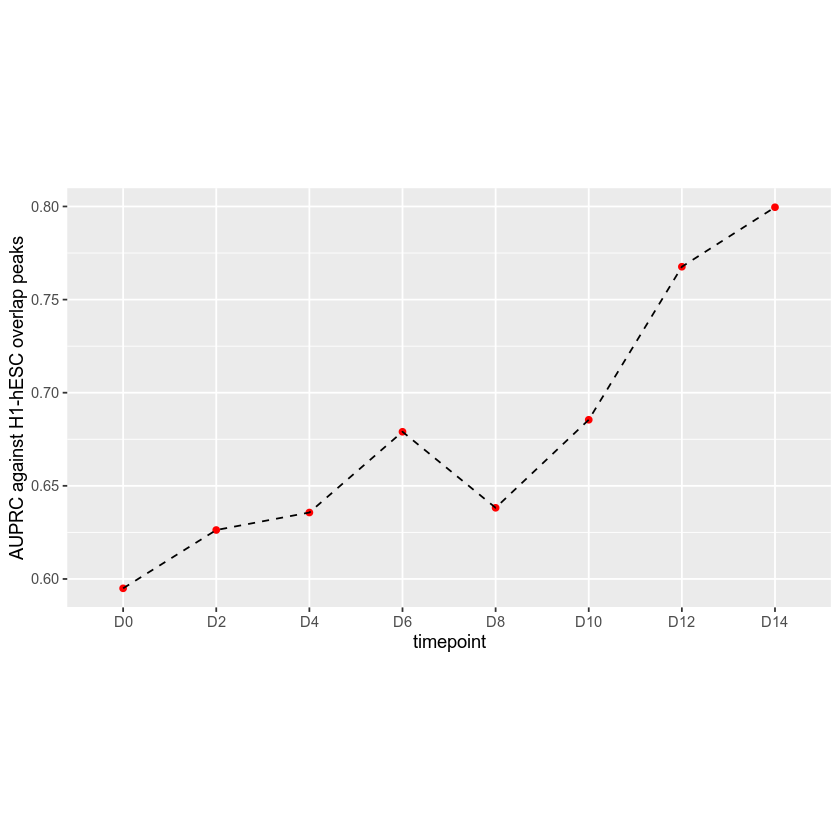

In [62]:
ggplot(data=auprc_df, aes(x=timepoint, y=auprcs_to_overlap, group=1)) +
  geom_point(color="red")+
  geom_line(linetype="dashed")+
    ylab("AUPRC against H1-hESC overlap peaks") + 
scale_x_discrete(limits=colnames(cts)) + 
coord_fixed(ratio=20)